## Save graced parquet to tiff

In [1]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd
import multiprocessing
import xarray as xr
import rioxarray
import os
import numpy as np

In [2]:
graced_path = "/shared/data/building-emissions/data/processing_file_edgar_graced/graced_building_area/reallocated_graced.parquet"
graced_floor_area_path = "/shared/data/building-emissions/data/processing_file_edgar_graced/graced_building_total_floor_area/reallocated_graced_new.parquet"

In [3]:
graced_reallocated = pd.read_parquet(graced_path)
graced_reallocated.head()

,y,x,area,graced_index,total_emissions_2019,lat,lon,geometry,area_emission,sum_area,area_emission_portion,non_water_body,count_non_water_body,area_emission_portion_w_0_distribution,count_grids
0,8999500.0,18040500.0,0,6479999,0.0,89.95,179.95,b'\x01\x01\x00\x00\x00\x00\x00\x00@k4qA\x00\x0...,0.0,0,0.0,0,0,0.0,510
1,8999500.0,18039500.0,0,6479999,0.0,89.95,179.95,"b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0,4qA\x00...",0.0,0,0.0,0,0,0.0,510
2,8999500.0,18038500.0,0,6479999,0.0,89.95,179.95,b'\x01\x01\x00\x00\x00\x00\x00\x00@\xee3qA\x00...,0.0,0,0.0,0,0,0.0,510
3,8999500.0,18037500.0,0,6479999,0.0,89.95,179.95,b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0\xaf3qA\...,0.0,0,0.0,0,0,0.0,510
4,8999500.0,18036500.0,0,6479999,0.0,89.95,179.95,b'\x01\x01\x00\x00\x00\x00\x00\x00@q3qA\x00\x0...,0.0,0,0.0,0,0,0.0,510


In [4]:
graced_reallocated_new = graced_reallocated[
    ["y", "x", "area_emission_portion_w_0_distribution"]
].copy()
graced_reallocated_new.head()

,y,x,area_emission_portion_w_0_distribution
0,8999500.0,18040500.0,0.0
1,8999500.0,18039500.0,0.0
2,8999500.0,18038500.0,0.0
3,8999500.0,18037500.0,0.0
4,8999500.0,18036500.0,0.0


In [6]:
# # if non_water_body == 0, then the grid is water body, replace the emission portion with 4294967295
# graced_reallocated_new = graced_reallocated[['y','x','area_emission_portion_w_0_distribution','non_water_body']].copy()
# graced_reallocated_new.loc[graced_reallocated_new.non_water_body == 0, 'area_emission_portion_w_0_distribution'] = 4294967295
# graced_reallocated_new.head()

,y,x,area_emission_portion_w_0_distribution,non_water_body
36081,8999500.0,18040500.0,4.294967e+09,0
36080,8999500.0,18039500.0,4.294967e+09,0
36079,8999500.0,18038500.0,4.294967e+09,0
36078,8999500.0,18037500.0,4.294967e+09,0
36077,8999500.0,18036500.0,4.294967e+09,0


In [5]:
# sort y in descending order, then sort x in ascending order
sorted_graced = graced_reallocated_new.sort_values(
    by=["y", "x"], ascending=[False, True]
)
sorted_graced

,y,x,area_emission_portion_w_0_distribution
36081,8999500.0,-18040500.0,0.0
36080,8999500.0,-18039500.0,0.0
36079,8999500.0,-18038500.0,0.0
36078,8999500.0,-18037500.0,0.0
36077,8999500.0,-18036500.0,0.0
...,...,...,...
649439922,-8999500.0,18036500.0,0.0
649439921,-8999500.0,18037500.0,0.0
649439920,-8999500.0,18038500.0,0.0
649439919,-8999500.0,18039500.0,0.0


In [6]:
latitudes = sorted_graced.y.unique()
longitudes = sorted_graced.x.unique()
print(latitudes, longitudes)

lat_grid, lon_grid = np.meshgrid(latitudes, longitudes, indexing="ij")

graced_2d = sorted_graced["area_emission_portion_w_0_distribution"].values.reshape(
    lat_grid.shape
)

graced_xr = xr.DataArray(
    graced_2d,
    dims=["latitude", "longitude"],
    coords={"latitude": latitudes, "longitude": longitudes},
)

graced_xr.rio.write_crs("epsg:4326", inplace=True)

graced_xr.rio.to_raster("/home/yz792/reallocated_graced_on_building_area_2.tif")

[ 8999500.  8998500.  8997500. ... -8997500. -8998500. -8999500.] [-18040500. -18039500. -18038500. ...  18038500.  18039500.  18040500.]


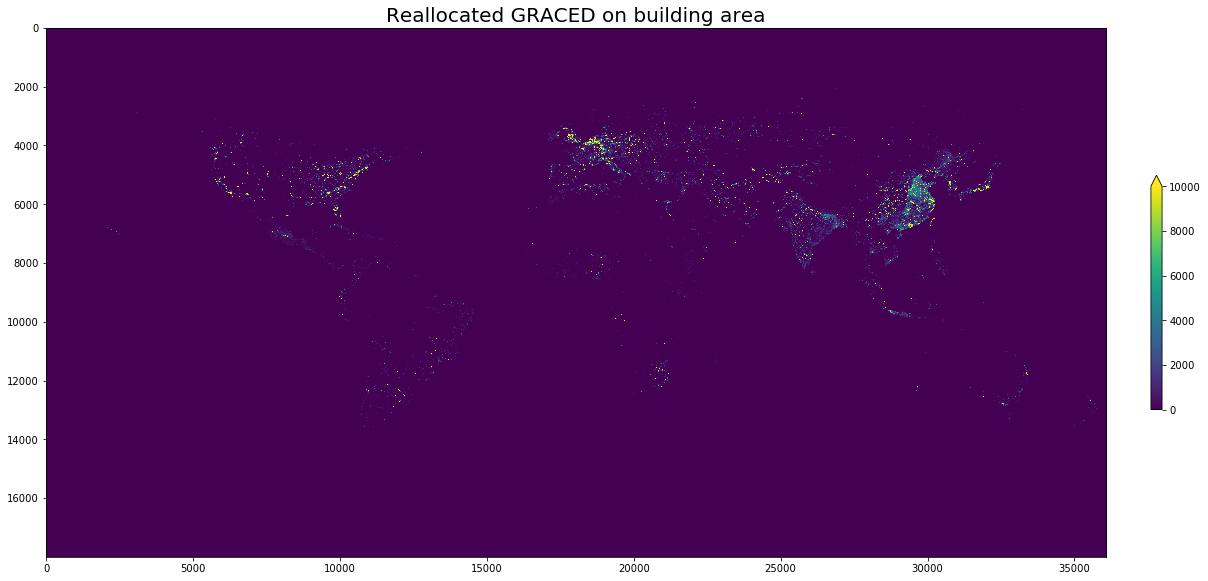

In [8]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Open the raster file
with rasterio.open("/home/yz792/reallocated_graced_on_building_area.tif") as src:
    # Define the maximum value for the colorbar
    max_value = 10000  # You should adjust this value based on your data

    # Plotting the image with a defined colorbar max value
    fig, ax = plt.subplots()
    # fig size
    fig.set_size_inches(20, 20)
    # set title
    ax.set_title("Reallocated GRACED on building area", fontsize=20)
    show(
        src, ax=ax, vmax=max_value, cmap="viridis"
    )  # You can choose a different colormap if you like

    # Adding a colorbar with size adjustments
    img = ax.imshow(src.read(1), cmap="viridis", vmax=max_value)
    cbar = fig.colorbar(img, ax=ax, extend="max", fraction=0.01, pad=0.04)

    # Show the plot
    plt.show()

In [3]:
graced_floor_area = pd.read_parquet(graced_floor_area_path)
graced_floor_area.head()

,y,x,area,non_water_body,graced_index,total_emissions_2019,lat,lon,geometry,area_emission,sum_area,area_emission_portion,count_non_water_body,area_emission_portion_w_0_distribution,count_grids
0,8999500.0,18040500.0,0.0,0,6479999,0.0,89.95,179.95,b'\x01\x01\x00\x00\x00\x00\x00\x00@k4qA\x00\x0...,0.0,0.0,0.0,0,0.0,510
1,8999500.0,18039500.0,0.0,0,6479999,0.0,89.95,179.95,"b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0,4qA\x00...",0.0,0.0,0.0,0,0.0,510
2,8999500.0,18038500.0,0.0,0,6479999,0.0,89.95,179.95,b'\x01\x01\x00\x00\x00\x00\x00\x00@\xee3qA\x00...,0.0,0.0,0.0,0,0.0,510
3,8999500.0,18037500.0,0.0,0,6479999,0.0,89.95,179.95,b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0\xaf3qA\...,0.0,0.0,0.0,0,0.0,510
4,8999500.0,18036500.0,0.0,0,6479999,0.0,89.95,179.95,b'\x01\x01\x00\x00\x00\x00\x00\x00@q3qA\x00\x0...,0.0,0.0,0.0,0,0.0,510


In [4]:
graced_floor_area_new = graced_floor_area[
    ["y", "x", "area_emission_portion_w_0_distribution"]
].copy()
graced_floor_area_new.head()

,y,x,area_emission_portion_w_0_distribution
0,8999500.0,18040500.0,0.0
1,8999500.0,18039500.0,0.0
2,8999500.0,18038500.0,0.0
3,8999500.0,18037500.0,0.0
4,8999500.0,18036500.0,0.0


In [5]:
# sort y in descending order, then sort x in ascending order
sorted_graced_floor_area = graced_floor_area_new.sort_values(
    by=["y", "x"], ascending=[False, True]
)
sorted_graced_floor_area

,y,x,area_emission_portion_w_0_distribution
36081,8999500.0,-18040500.0,0.0
36080,8999500.0,-18039500.0,0.0
36079,8999500.0,-18038500.0,0.0
36078,8999500.0,-18037500.0,0.0
36077,8999500.0,-18036500.0,0.0
...,...,...,...
649439922,-8999500.0,18036500.0,0.0
649439921,-8999500.0,18037500.0,0.0
649439920,-8999500.0,18038500.0,0.0
649439919,-8999500.0,18039500.0,0.0


In [6]:
latitudes = sorted_graced_floor_area.y.unique()
longitudes = sorted_graced_floor_area.x.unique()

lat_grid, lon_grid = np.meshgrid(latitudes, longitudes, indexing="ij")

grace_floor_area_2d = sorted_graced_floor_area[
    "area_emission_portion_w_0_distribution"
].values.reshape(lat_grid.shape)

grace_floor_area_xr = xr.DataArray(
    grace_floor_area_2d,
    dims=["latitude", "longitude"],
    coords={"latitude": latitudes, "longitude": longitudes},
)

grace_floor_area_xr.rio.write_crs("epsg:4326", inplace=True)

grace_floor_area_xr.rio.to_raster(
    "/home/yz792/reallocated_graced_on_building_floor_area.tif"
)

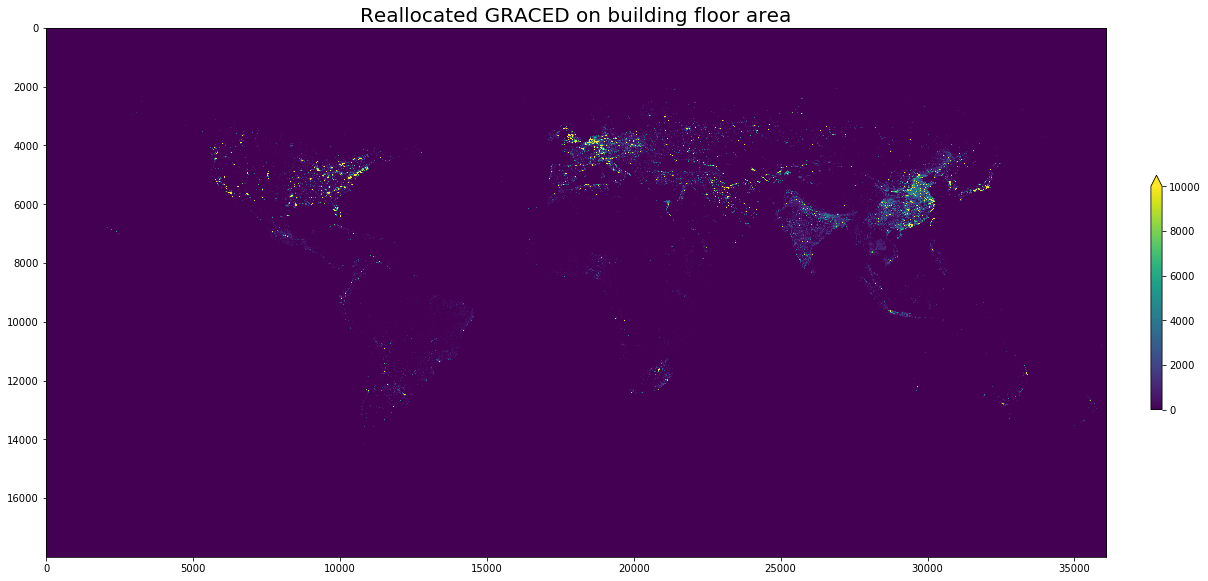

In [7]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Open the raster file
with rasterio.open("/home/yz792/reallocated_graced_on_building_floor_area.tif") as src:
    # Define the maximum value for the colorbar
    max_value = 10000  # You should adjust this value based on your data

    # Plotting the image with a defined colorbar max value
    fig, ax = plt.subplots()
    # fig size
    fig.set_size_inches(20, 20)
    # set title
    ax.set_title("Reallocated GRACED on building floor area", fontsize=20)
    show(
        src, ax=ax, vmax=max_value, cmap="viridis"
    )  # You can choose a different colormap if you like

    # Adding a colorbar with size adjustments
    img = ax.imshow(src.read(1), cmap="viridis", vmax=max_value)
    cbar = fig.colorbar(img, ax=ax, extend="max", fraction=0.01, pad=0.04)

    # Show the plot
    plt.show()

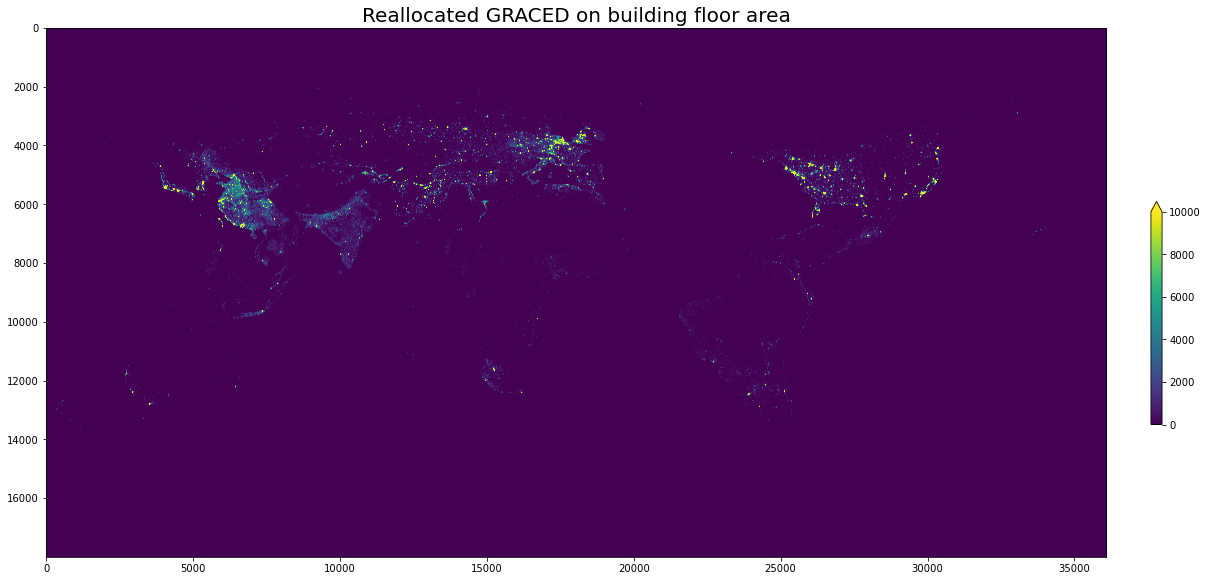

In [12]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Open the raster file
with rasterio.open("/home/yz792/reallocated_graced_on_building_area.tif") as src:
    # Define the maximum value for the colorbar
    max_value = 10000  # You should adjust this value based on your data

    # Plotting the image with a defined colorbar max value
    fig, ax = plt.subplots()
    # fig size
    fig.set_size_inches(20, 20)
    # set title
    ax.set_title("Reallocated GRACED on building floor area", fontsize=20)
    show(
        src, ax=ax, vmax=max_value, cmap="viridis"
    )  # You can choose a different colormap if you like

    # Adding a colorbar with size adjustments
    img = ax.imshow(src.read(1), cmap="viridis", vmax=max_value)
    cbar = fig.colorbar(img, ax=ax, extend="max", fraction=0.01, pad=0.04)

    # Show the plot
    plt.show()

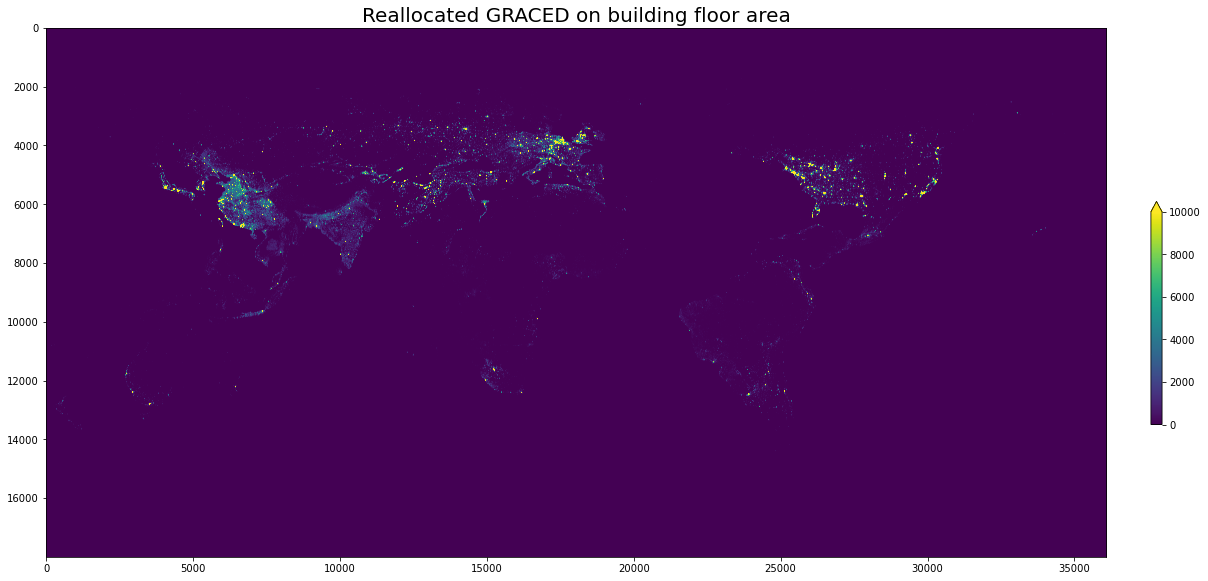

In [7]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Open the raster file
with rasterio.open("/home/yz792/reallocated_graced_on_building_floor_area.tif") as src:
    # Define the maximum value for the colorbar
    max_value = 10000  # You should adjust this value based on your data

    # Plotting the image with a defined colorbar max value
    fig, ax = plt.subplots()
    # fig size
    fig.set_size_inches(20, 20)
    # set title
    ax.set_title("Reallocated GRACED on building floor area", fontsize=20)
    show(
        src, ax=ax, vmax=max_value, cmap="viridis"
    )  # You can choose a different colormap if you like

    # Adding a colorbar with size adjustments
    img = ax.imshow(src.read(1), cmap="viridis", vmax=max_value)
    cbar = fig.colorbar(img, ax=ax, extend="max", fraction=0.01, pad=0.04)

    # Show the plot
    plt.show()

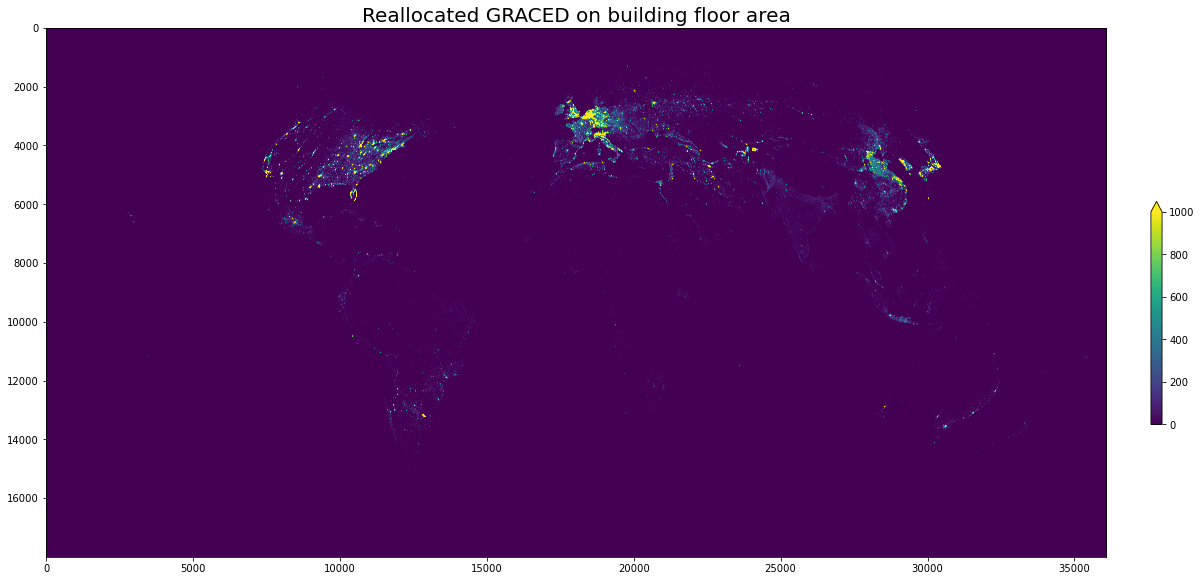

In [11]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Open the raster file
with rasterio.open(
    "/shared/data/building-emissions/data/geotiff_float64/total_co2eq_20yr.tif"
) as src:
    # Define the maximum value for the colorbar
    max_value = 1000  # You should adjust this value based on your data

    # Plotting the image with a defined colorbar max value
    fig, ax = plt.subplots()
    # fig size
    fig.set_size_inches(20, 20)
    # set title
    ax.set_title("Reallocated GRACED on building floor area", fontsize=20)
    show(
        src, ax=ax, vmax=max_value, cmap="viridis"
    )  # You can choose a different colormap if you like

    # Adding a colorbar with size adjustments
    img = ax.imshow(src.read(1), cmap="viridis", vmax=max_value)
    cbar = fig.colorbar(img, ax=ax, extend="max", fraction=0.01, pad=0.04)

    # Show the plot
    plt.show()